In [ ]:
# Описание признаков
# animal_name - Название животного (строковый идентификатор)
# hair - Наличие шерсти (бинарный)
# feathers - Наличие перьев (бинарный)
# eggs - Откладывает яйца (бинарный)
# milk - Производит молоко (бинарный)
# airborne - Способность летать (бинарный)
# aquatic - Водный обитатель (бинарный)
# predator - Хищник (бинарный)
# toothed - Наличие зубов (бинарный)
# backbone - Наличие позвоночника (бинарный)
# breathes - Дыхание легкими (1) или жабрами (0)
# venomous - Ядовитость (бинарный)
# fins - Наличие плавников (бинарный)
# legs - Количество конечностей (числовой: 0-8)
# tail - Наличие хвоста (бинарный)
# domestic - Домашнее животное (бинарный)
# catsize - Размер с кошку или больше (бинарный)
# class_type - Класс животного (категориальный)

#Задача многоклассовой классификации. 
#Целевая переменная: class_type

In [79]:
import pandas as pd                     
import numpy as np                      
import matplotlib.pyplot as plt         
from sklearn.model_selection import train_test_split  
from sklearn.metrics import (
    precision_recall_curve, 
    average_precision_score, 
    classification_report              
)
from sklearn.preprocessing import label_binarize       
from sklearn.neighbors import KNeighborsClassifier     
from sklearn.linear_model import Perceptron            


In [9]:
print("Количество строк до удаления дубликатов")
zoo = pd.read_csv('zoo.csv')
zoo.shape

Количество строк до удаления дубликатов


(101, 18)

In [10]:
#удаление дубликатов
zoo = zoo.drop_duplicates()
print("Количество строк после удаления дубликатов")
zoo.shape

Количество строк после удаления дубликатов


(101, 18)

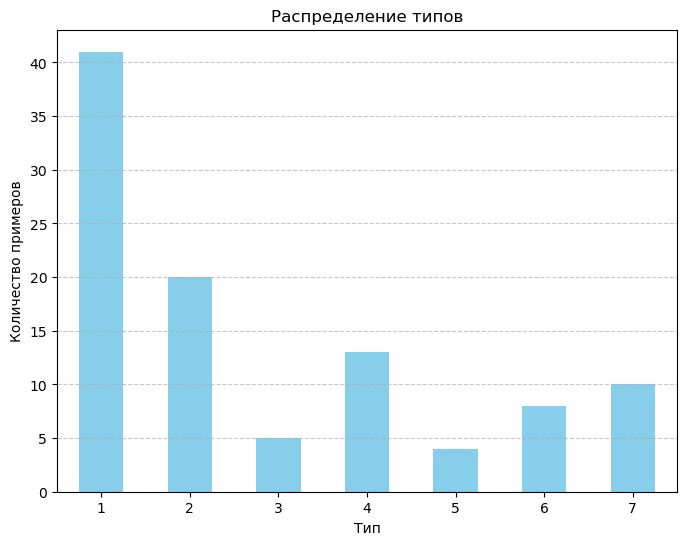

Распределение типов:
class_type
1    41
2    20
3     5
4    13
5     4
6     8
7    10
Name: count, dtype: int64


In [11]:
#Оценка сбалансированности данных
class_distribution = zoo["class_type"].value_counts().sort_index()

plt.figure(figsize=(8, 6))
class_distribution.plot(kind="bar", color="skyblue")
plt.title("Распределение типов")
plt.xlabel("Тип")
plt.ylabel("Количество примеров")
plt.xticks(rotation=0)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()
print(f"Распределение типов:\n{class_distribution}")

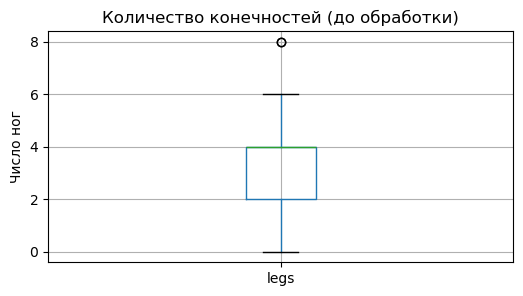

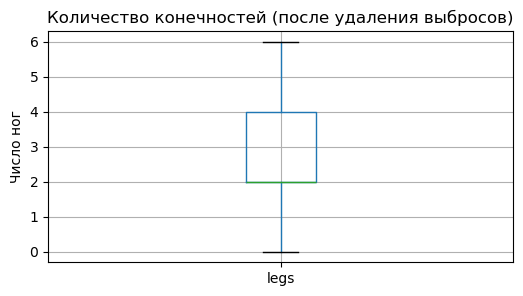

Было записей: 101
Осталось записей: 99
Удалено выбросов: 2


In [19]:
#Boxplot до обработки
plt.figure(figsize=(6, 3))
zoo[['legs']].boxplot()
plt.title('Количество конечностей (до обработки)')
plt.ylabel('Число ног')
plt.show()

#Удаление выбросов по правилу 1.5*IQR 
Q1 = zoo['legs'].quantile(0.25) # только для legs, так как остальные столбцы бинарные
Q3 = zoo['legs'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Фильтруем весь zoo, оставляя только строки, где legs в допустимом диапазоне
clean_data = zoo[(zoo['legs'] >= lower_bound) & (zoo['legs'] <= upper_bound)].copy()

#Boxplot после обработки
plt.figure(figsize=(6, 3))
clean_data[['legs']].boxplot()
plt.title('Количество конечностей (после удаления выбросов)')
plt.ylabel('Число ног')
plt.show()

#вывод статистики
print(f"Было записей: {len(zoo)}")
print(f"Осталось записей: {len(clean_data)}")
print(f"Удалено выбросов: {len(zoo) - len(clean_data)}")

In [20]:
#Проверка пропущенных значений
clean_data.isnull().sum()

animal_name    0
hair           0
feathers       0
eggs           0
milk           0
airborne       0
aquatic        0
predator       0
toothed        0
backbone       0
breathes       0
venomous       0
fins           0
legs           0
tail           0
domestic       0
catsize        0
class_type     0
dtype: int64

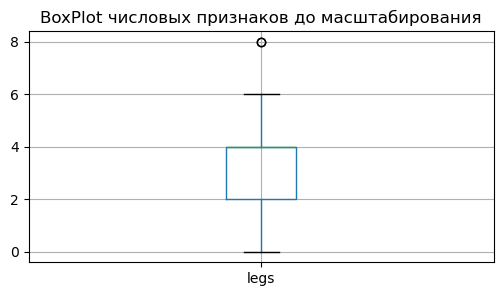

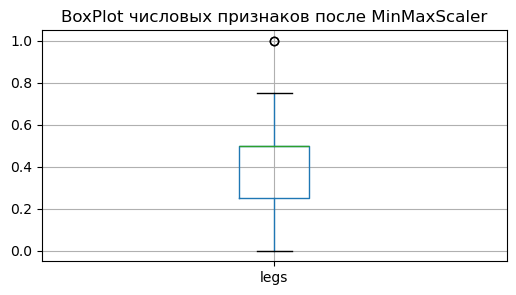

In [26]:
numeric_cols = ['legs']  
numeric_data = zoo[numeric_cols].copy()

#BoxPlot до масштабирования
plt.figure(figsize=(6, 3))
numeric_data.boxplot()
plt.title('BoxPlot числовых признаков до масштабирования')
plt.show()

#способ масштабирования - MinMaxScaler
scaler = MinMaxScaler()

#выполнение масштабирования
scaled_data = scaler.fit_transform(numeric_data)
scaled_df = pd.DataFrame(scaled_data, columns=numeric_cols)

#BoxPlot после масштабирования
plt.figure(figsize=(6, 3))
scaled_df.boxplot()
plt.title('BoxPlot числовых признаков после MinMaxScaler')
plt.show()

zoo_scaled = zoo.copy()
zoo_scaled[numeric_cols] = scaled_df

In [27]:
clean_data.to_csv('clean_zoo_data.csv', index=False)

In [30]:
#объединение файлов
class_df = pd.read_csv('class.csv')
clean_zoo_data = pd.read_csv('clean_zoo_data.csv')

class_df['Animal_List'] = class_df['Animal_Names'].str.split(', ')
exploded_class = class_df.explode('Animal_List')
exploded_class['Animal_Name_Clean'] = exploded_class['Animal_List'].str.strip().str.lower()
clean_zoo_data['animal_name_clean'] = clean_zoo_data['animal_name'].str.strip().str.lower()

merged_data = pd.merge(
    clean_zoo_data,
    exploded_class[['Animal_Name_Clean', 'Class_Number', 'Class_Type']],
    left_on='animal_name_clean',
    right_on='Animal_Name_Clean',
    how='left'
)

final_data = merged_data.drop(['animal_name_clean', 'Animal_Name_Clean'], axis=1)

mismatch = final_data[final_data['class_type'] != final_data['Class_Number']]
print(f"Найдено {len(mismatch)} несоответствий")

final_data.to_csv('zoo_with_class_info.csv', index=False)

Найдено 0 несоответствий


In [32]:
data = pd.read_csv('zoo_with_class_info.csv')

#Создаем OneHotEncoder
#Используем OneHotEncoder, так как он представляет категориальную переменную, содержащую дискретные числовые значения, обозначающие классы животных.
#Данные в файле не являются количественными.
encoder = OneHotEncoder(sparse_output=False, drop='first')  # drop='first' чтобы избежать мультиколлинеарности
class_encoded = encoder.fit_transform(data[['Class_Type']])

#создаем DataFrame с закодированными признаками
encoded_df = pd.DataFrame(
    class_encoded,
    columns=encoder.get_feature_names_out(['Class_Type'])
)

#объединяем с исходными данными
final_data = pd.concat([data.drop('Class_Type', axis=1), encoded_df], axis=1)

#Сохраняем результат
final_data.to_csv('zoo_encoded.csv', index=False)

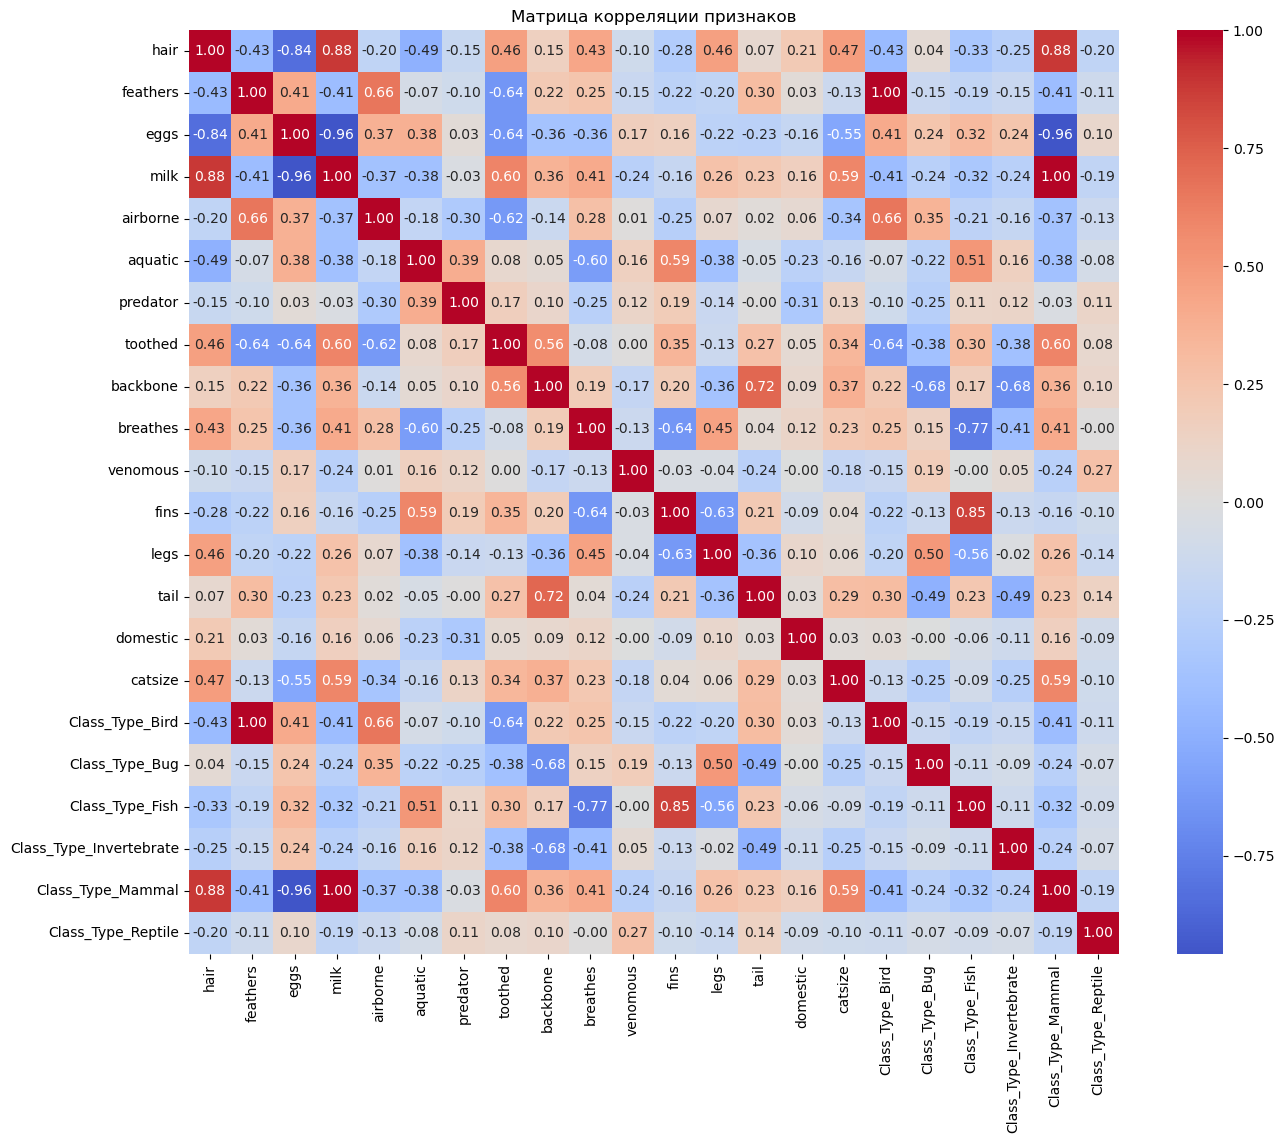

Топ признаков по количеству корреляций (|r| > 0.5):
toothed: 7 корреляций
eggs: 5 корреляций
milk: 5 корреляций
Class_Type_Mammal: 5 корреляций
backbone: 4 корреляций


In [82]:
data = pd.read_csv('zoo_encoded.csv')

numeric_data = data.drop(['animal_name', 'class_type', 'Class_Number'], axis=1, errors='ignore')
corr_matrix = numeric_data.corr()

#Визуализация
plt.figure(figsize=(15, 12))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', center=0)
plt.title('Матрица корреляции признаков')
plt.show()

high_corr_features = {}
threshold = 0.5

for column in corr_matrix.columns:
    #исключаем корреляцию с самим собой
    high_corr_count = (abs(corr_matrix[column]) > threshold).sum() - 1  
    high_corr_features[column] = high_corr_count

#сортируем по убыванию
sorted_features = sorted(high_corr_features.items(), key=lambda x: x[1], reverse=True)

#Выводим топ-5 признаков
print("Топ признаков по количеству корреляций (|r| > 0.5):")
for feature, count in sorted_features[:5]:
    print(f"{feature}: {count} корреляций")

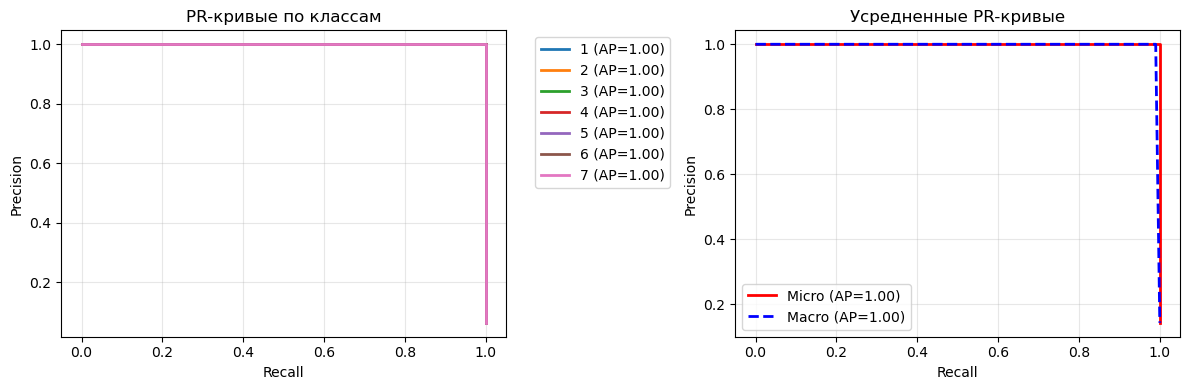


Итоговые метрики:
Micro Average Precision: 1.000
Macro Average Precision: 1.000

AP по классам:
1: 1.000
2: 1.000
3: 1.000
4: 1.000
5: 1.000
6: 1.000
7: 1.000


In [83]:
data = pd.read_csv('zoo_encoded.csv')
X = data.drop(['animal_name', 'class_type', 'Class_Number'], axis=1, errors='ignore')
y = data['class_type']

#разделение данных
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.3, 
    random_state=42, 
    stratify=y
)

#настройка модели и подбор параметров
model = OneVsRestClassifier(RandomForestClassifier(random_state=42, class_weight='balanced'))

param_grid = {
    'estimator__n_estimators': [50, 100],
    'estimator__max_depth': [5, 10, None],
    'estimator__min_samples_split': [2, 5],
    'estimator__max_features': ['sqrt', 0.5]
}

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=42),
    scoring='average_precision',
    refit=True,
    n_jobs=-1
)
grid_search.fit(X_train, y_train)

#Предсказания и вычисление метрик
y_proba = grid_search.predict_proba(X_test)
y_test_bin = label_binarize(y_test, classes=grid_search.classes_)

# Вычисление AP для каждого класса
ap_scores = []
for i, class_label in enumerate(grid_search.classes_):
    ap = average_precision_score(
        (y_test == class_label).astype(int),
        y_proba[:, i]
    )
    ap_scores.append(ap)

macro_ap = np.mean(ap_scores)
micro_ap = average_precision_score(y_test_bin, y_proba, average='micro')

#Визуализация PR-кривых
plt.figure(figsize=(12, 4))

#Первый график: PR-кривые по классам
plt.subplot(1, 2, 1)
for i, class_label in enumerate(grid_search.classes_):
    precision, recall, _ = precision_recall_curve(
        (y_test == class_label).astype(int),
        y_proba[:, i]
    )
    plt.plot(recall, precision, lw=2, label=f'{class_label} (AP={ap_scores[i]:.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('PR-кривые по классам')
plt.legend(bbox_to_anchor=(1.05, 1))
plt.grid(alpha=0.3)

#второй график: Усредненные кривые
plt.subplot(1, 2, 2)
#Микро-усреднение
precision_micro, recall_micro, _ = precision_recall_curve(
    y_test_bin.ravel(),
    y_proba.ravel()
)
plt.plot(recall_micro, precision_micro, 
         label=f'Micro (AP={micro_ap:.2f})',
         color='red', linewidth=2)

#Макро-усреднение
all_recalls = np.linspace(0, 1, 100)
precisions = []
for i in range(len(grid_search.classes_)):
    prec, rec, _ = precision_recall_curve(
        (y_test == grid_search.classes_[i]).astype(int),
        y_proba[:, i]
    )
    prec_interp = np.interp(all_recalls, rec[::-1], prec[::-1])
    precisions.append(prec_interp)

macro_precision = np.mean(precisions, axis=0)
plt.plot(all_recalls, macro_precision, 
         label=f'Macro (AP={macro_ap:.2f})',
         color='blue', linestyle='--', linewidth=2)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Усредненные PR-кривые')
plt.legend()
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("\nИтоговые метрики:")
print(f"Micro Average Precision: {micro_ap:.3f}")
print(f"Macro Average Precision: {macro_ap:.3f}")
print("\nAP по классам:")
for cls, ap in zip(grid_search.classes_, ap_scores):
    print(f"{cls}: {ap:.3f}")

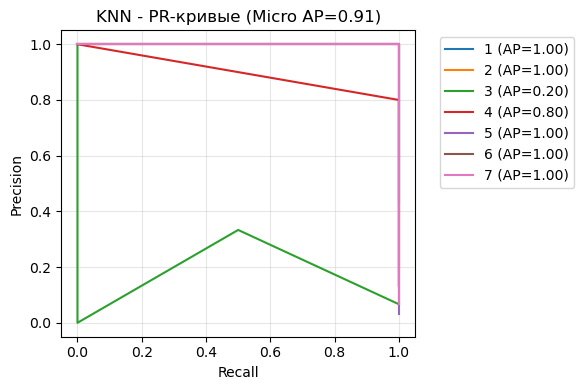


KNN - Средняя точность по классам:
1: 1.000
2: 1.000
3: 0.200
4: 0.800
5: 1.000
6: 1.000
7: 1.000
Micro Average Precision: 0.914


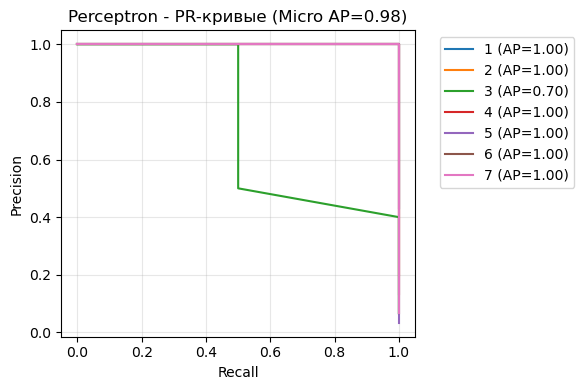


Perceptron - Средняя точность по классам:
1: 1.000
2: 1.000
3: 0.700
4: 1.000
5: 1.000
6: 1.000
7: 1.000
Micro Average Precision: 0.983


In [78]:
#Оборачиваем модели в OneVsRest, т.к. задача многоклассовая
knn_model = OneVsRestClassifier(KNeighborsClassifier(n_neighbors=5))
perceptron_model = OneVsRestClassifier(Perceptron(max_iter=1000, tol=1e-3, random_state=42))

#обучение
knn_model.fit(X_train, y_train)
perceptron_model.fit(X_train, y_train)

#Предсказания вероятностей / оценок
knn_proba = knn_model.predict_proba(X_test)
perceptron_scores = perceptron_model.decision_function(X_test)  # Perceptron не даёт вероятности

#Бинаризация целевых значений
y_test_bin = label_binarize(y_test, classes=knn_model.classes_)

#Функция для подсчёта AP и рисования PR-кривых
def plot_pr_curves(model_name, scores):
    ap_scores = []
    plt.figure(figsize=(6, 4))
    for i, class_label in enumerate(knn_model.classes_):
        y_true = (y_test == class_label).astype(int)
        precision, recall, _ = precision_recall_curve(y_true, scores[:, i])
        ap = average_precision_score(y_true, scores[:, i])
        ap_scores.append(ap)
        plt.plot(recall, precision, label=f'{class_label} (AP={ap:.2f})')

    micro_ap = average_precision_score(y_test_bin, scores, average='micro')
    plt.title(f'{model_name} - PR-кривые (Micro AP={micro_ap:.2f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend(bbox_to_anchor=(1.05, 1))
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

    print(f"\n{model_name} - Средняя точность по классам:")
    for cls, ap in zip(knn_model.classes_, ap_scores):
        print(f"{cls}: {ap:.3f}")
    print(f"Micro Average Precision: {micro_ap:.3f}")

plot_pr_curves("KNN", knn_proba)
plot_pr_curves("Perceptron", perceptron_scores)

In [ ]:
# Линейный классификатор (персептрон) справился с задачей лучше, чем KNN:
# Выше micro average precision.
# Более равномерное качество по всем классам.
# Лучше классифицирует трудный класс 3.